<a href="https://colab.research.google.com/github/mili189/ASK2026_Semiconductor_FDC/blob/main/LTSF_Linear_%EC%A0%84%EC%B2%98%EB%A6%AC%EB%B0%A9%EB%B2%95%EA%B0%9C%EC%84%A0_%EC%8A%AC%EB%9D%BC%EC%9D%B4%EB%94%A9%EC%9C%88%EB%8F%84%EC%9A%B0%EC%A0%81%EC%9A%A9_260212.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
1. 구글드라이브 연결 및 데이터 로드
2. 식별 Column 정의
3. 전처리 함수는 스케일링-슬라이딩 윈도우 순
4. 스케일링은 전체를 기준으로 잡아야 웨이퍼 끼리 데이터를 비교하기에 용이
5. df_target에서 센서 데이터만 추출한 다음 스케일링 후 이를 Wafer_ID 등의 변수와 다시 그룹화
6. Wafer_ID(Wafer_col) 기준으로 슬라이딩 윈도우 적용함
'''
#구글드라이브 마운트
from google.colab import drive
import os


drive.mount('/content/drive')

#파라미터 설정, 데이터 로드, 데이터셋 분리
# ==========================================
# 1. 라이브러리 임포트 및 설정
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, f1_score
import os
import math

# CPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 2. 데이터 로드
# ==========================================
# 업로드된 파일명 사용 (환경에 맞게 경로 수정 가능)
file_path = "/content/drive/MyDrive/2026Conv_FDC/MACHINE_Data.xlsx"

if os.path.exists(file_path):
    print(f"Loading data from: {file_path}")
    if file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        df = pd.read_csv(file_path)
else:
    print("파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    # 임시 빈 데이터프레임 생성 (에러 방지용)
    df = pd.DataFrame()

# 센서 컬럼 정의
sensor_cols = [
    'BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A',
    'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err',
    'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err',
    'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve'
]

# ==========================================
# 3. 데이터 전처리 함수
# ==========================================
"""
    Wafer_ID 별로 그룹화하여 슬라이딩 윈도우를 적용하는 함수

    Args:
        df_target: 대상 데이터프레임
        wafer_col: Wafer ID 컬럼명
        sensor_cols: 센서 데이터 컬럼 리스트
        seq_len: 윈도우 크기
        scaler: 사용할 스케일러 (None이면 새로 생성)
        is_train: 학습 모드 여부 (True면 fit_transform, False면 transform)

    Returns:
        X_all: (N, seq_len, n_features) 형태의 numpy 배열
        scaler: 학습/사용된 스케일러
"""
def create_sequences_per_wafer(df_target, wafer_col, sensor_cols, seq_len, scaler=None, is_train=True):

    # 1. 스케일링 처리
    # (Wafer별로 따로 스케일링하면 Wafer 간의 상대적 크기 정보가 사라질 수 있으므로 전체 기준으로 합니다.)
    data_values = df_target[sensor_cols].values

    if is_train:
        # 학습용: Scaler 생성 및 학습
        if scaler is None:
            scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data_values)
    else:
        # 테스트용: 기존 Scaler 사용
        if scaler is None:
            raise ValueError("Test mode requires a fitted scaler.")
        data_scaled = scaler.transform(data_values)

    # 스케일링 된 데이터를 다시 DataFrame에 맵핑 (Wafer ID로 그룹핑하기 위해)
    df_scaled = pd.DataFrame(data_scaled, columns=sensor_cols, index=df_target.index)
    df_scaled[wafer_col] = df_target[wafer_col]

    all_sequences = []

    # 2. Wafer ID 별로 슬라이딩 윈도우 적용
    unique_wafers = df_scaled[wafer_col].unique()

    for wafer in unique_wafers:
        # 특정 Wafer 데이터 추출
        wafer_data = df_scaled[df_scaled[wafer_col] == wafer][sensor_cols].values

        # 데이터가 윈도우 크기보다 작으면 스킵
        if len(wafer_data) < seq_len:
            continue

        # 슬라이딩 윈도우 생성
        for i in range(len(wafer_data) - seq_len + 1):
            all_sequences.append(wafer_data[i : i + seq_len])

    if len(all_sequences) == 0:
        return np.array([]), scaler

    return np.array(all_sequences), scaler

# ==========================================
# 4. 데이터셋 구성 (실험별 루프)
# ==========================================
experiments = ['l29', 'l31', 'l33']
datasets = {}

print("\n--- Preprocessing Data (Per Wafer Logic) ---")

for exp_id in experiments:
    print(f"\nProcessing Experiment: {exp_id}")

    # 1. 해당 실험 데이터 추출
    exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False, na=False)]

    if exp_df.empty:
        print(f"No data for {exp_id}")
        continue

    # 2. Wafer ID 추출 및 분할 (Label 기준)
    # 정상 Wafer와 불량 Wafer의 ID 리스트를 확보
    normal_wafer_ids = exp_df[exp_df['Label'] == 'Normal']['Wafer_ID'].unique()
    fault_wafer_ids = exp_df[exp_df['Label'] == 'Fault']['Wafer_ID'].unique()

    print(f"  - Total Normal Wafers: {len(normal_wafer_ids)}")
    print(f"  - Total Fault Wafers: {len(fault_wafer_ids)}")

    # 정상 Wafer가 너무 적으면 스킵
    if len(normal_wafer_ids) < 4:
        print("  - Not enough normal wafers to split.")
        continue

    # 3. Train / Test Split (Wafer ID 기준)
    # 정상 Wafer 중 80%는 학습용, 20%는 테스트용
    n_train_wafers = int(len(normal_wafer_ids) * 0.8)

    train_wafer_ids = normal_wafer_ids[:n_train_wafers]
    test_norm_wafer_ids = normal_wafer_ids[n_train_wafers:]

    # ID를 기준으로 데이터프레임 필터링
    train_df = exp_df[exp_df['Wafer_ID'].isin(train_wafer_ids)]
    test_norm_df = exp_df[exp_df['Wafer_ID'].isin(test_norm_wafer_ids)]
    test_fault_df = exp_df[exp_df['Wafer_ID'].isin(fault_wafer_ids)]

    # 4. 슬라이딩 윈도우 파라미터 설정
    SEQ_LEN = 10

    # (1) Train Data: Fit & Transform
    # 여기서 만들어진 scaler를 반환받아 테스트셋에 적용합니다.
    X_train, scaler = create_sequences_per_wafer(
        train_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=None, is_train=True
    )

    # (2) Test Normal Data: Transform Only
    X_test_normal, _ = create_sequences_per_wafer(
        test_norm_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=scaler, is_train=False     # 학습 데이터로 변환한 Scaler 적용
    )

    # (3) Test Fault Data: Transform Only
    if not test_fault_df.empty:
        X_test_fault, _ = create_sequences_per_wafer(
            test_fault_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=scaler, is_train=False    # 학습 데이터로 변환한 Scaler 적용
        )
    else:
        X_test_fault = np.array([])

    # 5. 결과 저장
    datasets[exp_id] = {
        'X_train': X_train,
        'X_test_norm': X_test_normal,
        'X_test_fault': X_test_fault,
        'scaler': scaler
    }

    print(f"  -> [{exp_id}] Result Shapes:")
    print(f"     X_train     : {X_train.shape}")
    print(f"     X_test_norm : {X_test_normal.shape}")
    print(f"     X_test_fault: {X_test_fault.shape}")

print("\nData preprocessing completed.")


Mounted at /content/drive
Loading data from: /content/drive/MyDrive/2026Conv_FDC/MACHINE_Data.xlsx

--- Preprocessing Data (Per Wafer Logic) ---

Processing Experiment: l29
  - Total Normal Wafers: 34
  - Total Fault Wafers: 9
  -> [l29] Result Shapes:
     X_train     : (2546, 10, 19)
     X_test_norm : (634, 10, 19)
     X_test_fault: (832, 10, 19)

Processing Experiment: l31
  - Total Normal Wafers: 37
  - Total Fault Wafers: 6
  -> [l31] Result Shapes:
     X_train     : (2589, 10, 19)
     X_test_norm : (722, 10, 19)
     X_test_fault: (488, 10, 19)

Processing Experiment: l33
  - Total Normal Wafers: 37
  - Total Fault Wafers: 6
  -> [l33] Result Shapes:
     X_train     : (2607, 10, 19)
     X_test_norm : (706, 10, 19)
     X_test_fault: (550, 10, 19)

Data preprocessing completed.


In [2]:
'''
전처리 과정 검증용
'''

def inspect_sliding_window_logic(df, experiment_id, wafer_idx=0, seq_len=10):
    print(f"=== Sliding Window Verification for Experiment: {experiment_id} ===")

    # 1. 해당 실험의 특정 Wafer ID 하나 선택
    exp_df = df[df['Wafer_ID'].str.contains(experiment_id, case=False, na=False)]
    unique_wafers = exp_df['Wafer_ID'].unique()

    if len(unique_wafers) == 0:
        print("해당 실험 데이터가 없습니다.")
        return

    target_wafer = unique_wafers[wafer_idx] # 첫 번째 Wafer 선택
    print(f"Target Wafer ID: {target_wafer}")

    # 2. 원본 데이터(Raw) 추출
    # 전처리 때 사용한 센서 컬럼만 선택
    raw_data = exp_df[exp_df['Wafer_ID'] == target_wafer][sensor_cols].values
    raw_len = len(raw_data)

    print(f"Original Data Length (Rows): {raw_len}")
    print(f"Window Size (Seq_len): {seq_len}")

    # 3. 이론상 생성되어야 할 시퀀스 개수 계산
    # 공식: (원본 길이 - 윈도우 크기) + 1
    expected_sequences = raw_len - seq_len + 1
    print(f"Expected Sequences: {raw_len} - {seq_len} + 1 = {expected_sequences}")

    # 4. 실제 슬라이딩 윈도우 수행 (검증용 로직)
    actual_sequences = []
    for i in range(expected_sequences):
        actual_sequences.append(raw_data[i : i + seq_len])

    actual_sequences = np.array(actual_sequences)
    print(f"Generated Sequences Shape: {actual_sequences.shape}")

    if expected_sequences == actual_sequences.shape[0]:
        print(">> [PASS] 시퀀스 개수가 이론과 정확히 일치합니다.")
    else:
        print(">> [FAIL] 시퀀스 개수가 다릅니다!")

    print("\n--- Data Content Check (First 2 Sequences) ---")
    # 5. 데이터가 한 칸씩 밀렸는지 확인 (첫 번째 센서 기준)
    # 첫 번째 시퀀스 (Time 0 ~ 9)
    seq_0 = actual_sequences[0, :, 0] # 첫 번째 시퀀스의 첫 번째 센서 값들
    # 두 번째 시퀀스 (Time 1 ~ 10)
    seq_1 = actual_sequences[1, :, 0] # 두 번째 시퀀스의 첫 번째 센서 값들

    print(f"Seq 0 (Time 0~9) : {seq_0}")
    print(f"Seq 1 (Time 1~10): {seq_1}")

    # 비교: Seq 1의 앞부분(0~8)이 Seq 0의 뒷부분(1~9)과 같아야 함
    is_shifted_correctly = np.allclose(seq_0[1:], seq_1[:-1])

    print(f"\nVerifying Overlap (Seq 0[1:] == Seq 1[:-1]): {is_shifted_correctly}")
    if is_shifted_correctly:
        print(">> [PASS] 데이터가 정확히 1 Time Step씩 슬라이딩 되었습니다.")
    else:
        print(">> [FAIL] 데이터 슬라이딩이 올바르지 않습니다.")

# 검증 실행 (l29 실험의 첫 번째 Wafer 확인)
inspect_sliding_window_logic(df, 'l29', wafer_idx=0, seq_len=10)

import numpy as np

def verify_sliding_window_random(df, experiment_id, wafer_idx=0, seq_len=10):
    print(f"=== Random Sliding Window Verification for {experiment_id} ===")

    # 1. 데이터 준비 (이전과 동일)
    exp_df = df[df['Wafer_ID'].str.contains(experiment_id, case=False, na=False)]
    unique_wafers = exp_df['Wafer_ID'].unique()

    if len(unique_wafers) == 0:
        print("데이터 없음")
        return

    target_wafer = unique_wafers[wafer_idx]
    # 원본 데이터 (numpy array)
    raw_data = exp_df[exp_df['Wafer_ID'] == target_wafer][sensor_cols].values

    # 2. 슬라이딩 윈도우 생성
    sequences = []
    for i in range(len(raw_data) - seq_len + 1):
        sequences.append(raw_data[i : i + seq_len])
    sequences = np.array(sequences)

    total_seq = sequences.shape[0]
    print(f"Target Wafer: {target_wafer}")
    print(f"Total Generated Sequences: {total_seq}")

    # 3. 무작위 인덱스 선택 (마지막 인덱스는 다음 게 없으므로 제외)
    # 값이 변하는 것을 보기 위해 시도 횟수를 늘리거나 하지 않고, 순수 랜덤으로 뽑습니다.
    rand_idx = np.random.randint(0, total_seq - 1)

    print(f"\n--- Checking Random Index: {rand_idx} vs {rand_idx+1} ---")

    # 두 개의 연속된 시퀀스 추출
    seq_A = sequences[rand_idx]      # 현재 시퀀스
    seq_B = sequences[rand_idx + 1]  # 다음 시퀀스 (1 Time step 뒤)

    # 4. 비교를 위해 특정 센서 하나만 출력 (값이 좀 변하는 센서를 찾아서 출력하면 좋음)
    # 여기서는 6번째 센서(Pressure)나 10번째(RF Pwr) 등을 봅니다.
    target_sensor_idx = 6  # Pressure (예시)
    sensor_name = sensor_cols[target_sensor_idx]

    val_A = seq_A[:, target_sensor_idx]
    val_B = seq_B[:, target_sensor_idx]

    print(f"Sensor: {sensor_name}")
    print(f"Seq {rand_idx:<3} (t={rand_idx}~{rand_idx+9})   : {np.round(val_A, 2)}")
    print(f"Seq {rand_idx+1:<3} (t={rand_idx+1}~{rand_idx+10}): {np.round(val_B, 2)}")

    # 5. 시각적 검증 가이드
    print("\n[검증 가이드]")
    print(f"Seq {rand_idx}의 2번째 값({val_A[1]:.2f})부터 마지막 값까지가")
    print(f"Seq {rand_idx+1}의 1번째 값({val_B[0]:.2f})부터 9번째 값과 같아야 합니다.")

    # 6. 로직 검증
    # seq_A[1:] 과 seq_B[:-1] 이 같은지 확인
    is_match = np.allclose(seq_A[1:], seq_B[:-1])

    print(f"\n>> Overlap Check Result: {is_match}")
    if is_match:
        print(">> [SUCCESS] 데이터가 정확하게 한 칸씩 밀려있습니다.")
    else:
        print(">> [FAIL] 데이터 불일치 발생!")

# 실행
verify_sliding_window_random(df, 'l29', wafer_idx=0, seq_len=10)


def verify_wafer_aggregation(df, datasets, experiments, seq_len=10):
    print("="*60)
    print("      데이터셋 구성 무결성 검증 (Wafer Aggregation Check)")
    print("="*60)

    for exp_id in experiments:
        print(f"\nTarget Experiment: [{exp_id}]")

        # 1. 원본 데이터에서 Wafer ID 리스트 및 분할 로직 재현
        exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False, na=False)]
        if exp_df.empty: continue

        # Normal / Fault 분류
        normal_wafer_ids = exp_df[exp_df['Label'] == 'Normal']['Wafer_ID'].unique()
        fault_wafer_ids = exp_df[exp_df['Label'] == 'Fault']['Wafer_ID'].unique()

        # Train / Test Split (80:20) 로직 재현
        n_train = int(len(normal_wafer_ids) * 0.8)
        train_ids = normal_wafer_ids[:n_train]
        test_norm_ids = normal_wafer_ids[n_train:]
        test_fault_ids = fault_wafer_ids # 전체 사용

        # 검증 대상 맵핑
        targets = [
            ('X_train', train_ids),
            ('X_test_norm', test_norm_ids),
            ('X_test_fault', test_fault_ids)
        ]

        for key, wafer_ids in targets:
            # 저장된 실제 데이터 모양
            stored_data = datasets[exp_id][key]
            actual_count = stored_data.shape[0] if len(stored_data) > 0 else 0

            # 2. Wafer ID 별 기대 시퀀스 개수 계산
            expected_count = 0
            wafer_details = [] # 상세 로그용

            for wafer in wafer_ids:
                # 해당 Wafer의 원본 데이터 길이
                raw_len = len(exp_df[exp_df['Wafer_ID'] == wafer])

                # 시퀀스 생성 가능 개수 계산
                if raw_len >= seq_len:
                    seq_count = raw_len - seq_len + 1
                    expected_count += seq_count
                    wafer_details.append(f"{wafer}({seq_count})")
                else:
                    wafer_details.append(f"{wafer}(Skip:TooShort)")

            # 3. 비교 및 결과 출력
            print(f"  [{key}] Check:")
            print(f"    - Included Wafers ({len(wafer_ids)}): {', '.join(wafer_details[:5])} ...") # 5개만 예시 출력
            print(f"    - Expected Sum : {expected_count}")
            print(f"    - Actual Shape : {actual_count}")

            if expected_count == actual_count:
                print(f"    >> [PASS] {key} 데이터가 누락 없이 정확하게 합쳐졌습니다.")
            else:
                print(f"    >> [FAIL] 개수 불일치! (Diff: {actual_count - expected_count})")

    print("\nVerification Completed.")

# 검증 실행
verify_wafer_aggregation(df, datasets, experiments, seq_len=10)

=== Sliding Window Verification for Experiment: l29 ===
Target Wafer ID: l2901.txm
Original Data Length (Rows): 112
Window Size (Seq_len): 10
Expected Sequences: 112 - 10 + 1 = 103
Generated Sequences Shape: (103, 10, 19)
>> [PASS] 시퀀스 개수가 이론과 정확히 일치합니다.

--- Data Content Check (First 2 Sequences) ---
Seq 0 (Time 0~9) : [751. 751. 751. 751. 751. 751. 751. 751. 751. 751.]
Seq 1 (Time 1~10): [751. 751. 751. 751. 751. 751. 751. 751. 751. 751.]

Verifying Overlap (Seq 0[1:] == Seq 1[:-1]): True
>> [PASS] 데이터가 정확히 1 Time Step씩 슬라이딩 되었습니다.
=== Random Sliding Window Verification for l29 ===
Target Wafer: l2901.txm
Total Generated Sequences: 103

--- Checking Random Index: 48 vs 49 ---
Sensor: Pressure
Seq 48  (t=48~57)   : [1193. 1191. 1190. 1187. 1222. 1205. 1182. 1182. 1187. 1184.]
Seq 49  (t=49~58): [1191. 1190. 1187. 1222. 1205. 1182. 1182. 1187. 1184. 1184.]

[검증 가이드]
Seq 48의 2번째 값(1191.00)부터 마지막 값까지가
Seq 49의 1번째 값(1191.00)부터 9번째 값과 같아야 합니다.

>> Overlap Check Result: True
>> [SUCCESS] 데이

In [3]:
"""
LTSF_Linear 정의
"""

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

#클래스 정의
class LTSF_Linear(nn.Module):
    def __init__(self, window_size, forecast_size, individual, feature_size):
        super(LTSF_Linear, self).__init__()
        self.window_size = window_size
        self.forecast_size = forecast_size
        self.individual = individual
        self.feature_size = feature_size

        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.feature_size):
                self.Linear.append(nn.Linear(self.window_size, self.forecast_size))
        else:
            self.Linear = nn.Linear(self.window_size, self.forecast_size)

    def forward(self, x):
        # x: [Batch, Input_Step, Feature]
        if self.individual:
            # 출력을 담을 텐서 생성
            output = torch.zeros([x.size(0), self.forecast_size, x.size(2)], dtype=x.dtype).to(x.device)
            for i in range(self.feature_size):
                # 각 센서(Feature)별로 학습된 Linear 층 적용
                # x[:, :, i]는 [Batch, Input_Step] -> 결과는 [Batch, Forecast_Step]
                output[:, :, i] = self.Linear[i](x[:, :, i])
            return output  # 결과를 반환해야 합니다.
        else:
            # [Batch, Input_Step, Feature] -> [Batch, Feature, Input_Step] 차원 변경
            x = x.permute(0, 2, 1)
            # Linear 적용 후 다시 원래대로 변경
            x = self.Linear(x)
            x = x.permute(0, 2, 1)
            return x  # 'x = self'가 아니라 계산된 x를 반환해야 합니다.


In [15]:
"""
LTSF-DLinear (Trend와 Remainder 데이터의 Decomposition)
정의
"""
import torch
import torch.nn as nn

# 1. 시계열 분해를 위한 Moving Average 클래스
class moving_avg(nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # x: [Batch, Input_Step, Feature]
        # padding을 주어 출력 길이를 입력과 맞춤 (양 끝값 복제)
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        back = x[:, -1:, :].repeat(1, self.kernel_size // 2, 1)
        x = torch.cat([front, x, back], dim=1)
        x = x.permute(0, 2, 1) # [Batch, Feature, Input_Step]
        x = self.avg(x)
        x = x.permute(0, 2, 1) # [Batch, Input_Step, Feature]
        return x

class series_decomp(nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x) # Trend 성분 추출
        res = x - moving_mean            # Remainder 성분 추출
        return res, moving_mean

# 2. LTSF-DLinear 클래스 정의
class LTSF_DLinear(nn.Module):
    def __init__(self, window_size, forecast_size, individual, feature_size, kernel_size=25):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forecast_size = forecast_size
        self.individual = individual
        self.feature_size = feature_size

        # 시계열 분해 모듈
        self.decomposition = series_decomp(kernel_size)

        if self.individual:
            self.Linear_Trend = nn.ModuleList()
            self.Linear_Res = nn.ModuleList()
            for i in range(self.feature_size):
                self.Linear_Trend.append(nn.Linear(self.window_size, self.forecast_size))
                self.Linear_Res.append(nn.Linear(self.window_size, self.forecast_size))
        else:
            self.Linear_Trend = nn.Linear(self.window_size, self.forecast_size)
            self.Linear_Res = nn.Linear(self.window_size, self.forecast_size)

    def forward(self, x):
        # x: [Batch, Input_Step, Feature]
        # 1. 분해: Remainder(res)와 Trend(trend)로 나눔
        res, trend = self.decomposition(x)

        # 2. 각 성분에 대해 Linear 적용
        if self.individual:
            res_output = torch.zeros([x.size(0), self.forecast_size, x.size(2)], dtype=x.dtype).to(x.device)
            trend_output = torch.zeros([x.size(0), self.forecast_size, x.size(2)], dtype=x.dtype).to(x.device)

            for i in range(self.feature_size):
                res_output[:, :, i] = self.Linear_Res[i](res[:, :, i])
                trend_output[:, :, i] = self.Linear_Trend[i](trend[:, :, i])
        else:
            # [Batch, Input_Step, Feature] -> [Batch, Feature, Input_Step]
            res = res.permute(0, 2, 1)
            trend = trend.permute(0, 2, 1)

            res_output = self.Linear_Res(res).permute(0, 2, 1)
            trend_output = self.Linear_Trend(trend).permute(0, 2, 1)

        # 3. 두 성분을 다시 합쳐서 최종 복원/예측값 생성
        return res_output + trend_output

In [20]:
"""
NLinear 모델 정의

Linear 모델에 Normalization 작업이 추가된 것
시퀀스의 가장 마지막 값 (Drift가 발생한 최종 값)을
전체 시퀀스에서 다 빼줌으로써 상대적인 변화량만 남기고
이것을 선형회귀 연산하는 것
"""

class LTSF_NLinear(nn.Module):
    def __init__(self, window_size, forecast_size, individual, feature_size):
        super(LTSF_NLinear, self).__init__()
        self.window_size = window_size
        self.forecast_size = forecast_size
        self.individual = individual
        self.feature_size = feature_size

        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.feature_size):
                self.Linear.append(nn.Linear(self.window_size, self.forecast_size))
        else:
            self.Linear = nn.Linear(self.window_size, self.forecast_size)

    def forward(self, x):
        # x: [Batch, Input_Step, Feature]

        # 1. 마지막 값을 기준으로 정규화 (Normalization)
        seq_last = x[:, -1:, :].detach() # 마지막 시점의 값 추출
        x = x - seq_last                 # 모든 시점에서 마지막 값을 뺌

        # 2. Linear 연산
        if self.individual:
            output = torch.zeros([x.size(0), self.forecast_size, x.size(2)], dtype=x.dtype).to(x.device)
            for i in range(self.feature_size):
                output[:, :, i] = self.Linear[i](x[:, :, i])
        else:
            x = x.permute(0, 2, 1)
            x = self.Linear(x)
            output = x.permute(0, 2, 1)

        # 3. 다시 마지막 값을 더해줌 (Denormalization)
        output = output + seq_last
        return output


🚀 [l29] 실험 모델 학습 시작
Epoch [50/100], Loss: 0.000001
Epoch [100/100], Loss: 0.000000
✅ [l29] 학습 완료 및 모델 저장 성공

🚀 [l31] 실험 모델 학습 시작
Epoch [50/100], Loss: 0.000000
Epoch [100/100], Loss: 0.000000
✅ [l31] 학습 완료 및 모델 저장 성공

🚀 [l33] 실험 모델 학습 시작
Epoch [50/100], Loss: 0.000000
Epoch [100/100], Loss: 0.000000
✅ [l33] 학습 완료 및 모델 저장 성공


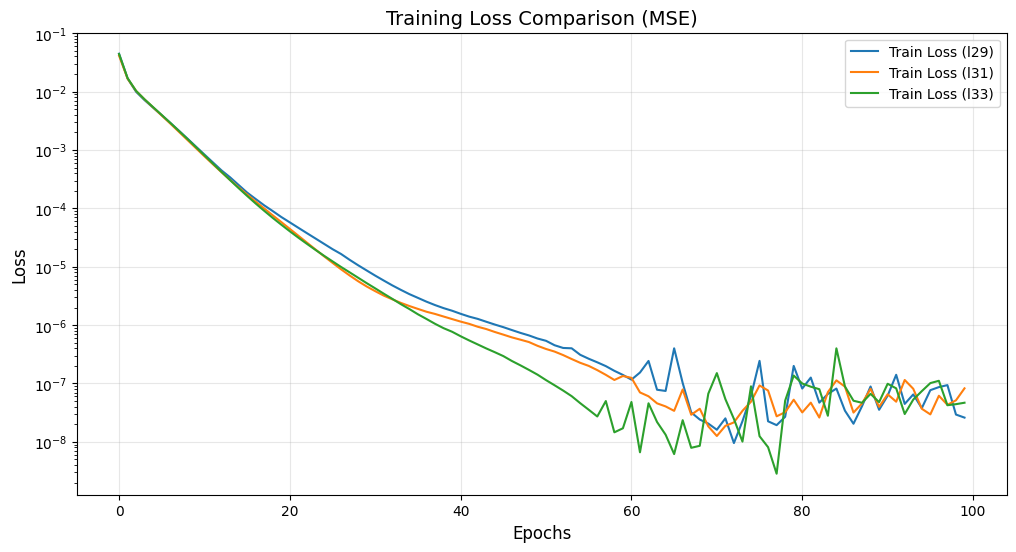

In [21]:
"""
학습
Exp No.에 따라
각기 다른 가중치를 저장하도록
빈 딕셔너리를 선언 후 가중치 정보 저장

또한, 학습 모델을
Linear, DLinear, NLinear 세 가지로 구성이 되어있음
model = LTSF_Linear(...
부분에서 주석처리를 통해 원하는 모델을 선택
"""

# 1. 모델들을 저장할 빈 딕셔너리 생성
models = {}
train_histories = {}

for exp_id in experiments:
    print(f"\n🚀 [{exp_id}] 실험 모델 학습 시작")

    # 해당 실험 데이터 가져오기
    exp_data = datasets[exp_id]
    X_train = torch.tensor(exp_data['X_train'], dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(X_train), batch_size=16, shuffle=True)

    n_samples, seq_len, n_feats = X_train.shape

    # 2. 각 실험별로 독립적인 모델 객체 생성
    # 2.1. LTSF_Linear (주석 지우고, DLinear엔 주석 처리 후 사용)
    '''
    model = LTSF_Linear(
    window_size=seq_len,
    forecast_size=seq_len,
    individual=True,
    feature_size=n_feats
).to('cuda' if torch.cuda.is_available() else 'cpu') # GPU 사용 시 추가
    '''

    # 2.2. LTSF_DLinear
    '''
    model = LTSF_DLinear(
    window_size=seq_len,
    forecast_size=seq_len,   # 복원 모델이므로 window_size와 동일하게 설정
    individual=True,
    feature_size=n_feats,
    kernel_size=25           # 분해를 위한 커널 사이즈 추가 (기본값 25 권장)
).to('cuda' if torch.cuda.is_available() else 'cpu')
    '''

    #2.3. LTSF_NLinear
    model = LTSF_NLinear(
        window_size=seq_len,
        forecast_size=seq_len,
        individual=True,
        feature_size=n_feats
    ).to('cuda' if torch.cuda.is_available() else 'cpu')



    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 3. 학습 루프
    epoch_losses = []
    model.train()
    for epoch in range(100):
        avg_loss = 0
        for batch in train_loader:
            inputs = batch[0].to(next(model.parameters()).device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

        epoch_losses.append(avg_loss / len(train_loader))
        if (epoch+1) % 50 == 0:
            print(f"Epoch [{epoch+1}/100], Loss: {epoch_losses[-1]:.6f}")

    # 4. 학습된 모델과 기록을 딕셔너리에 저장
    models[exp_id] = model
    train_histories[exp_id] = epoch_losses
    print(f"✅ [{exp_id}] 학습 완료 및 모델 저장 성공")

# 5. Training Loss 시각화
import matplotlib.pyplot as plt

# 시각화 설정
plt.figure(figsize=(12, 6))

# train_histories 딕셔너리에 저장된 데이터를 반복문으로 출력
for exp_id, losses in train_histories.items():
    plt.plot(losses, label=f'Train Loss ({exp_id})')

plt.title('Training Loss Comparison (MSE)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.yscale('log') # Loss 차이가 클 경우를 대비해 로그 스케일 권장
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [22]:
"""
데이터 시각화 코드
평가 코드 진행 전 선언
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve

def plot_model_results(exp_id, title, y_true, y_pred, ai_scores, threshold):
    # 1. 지표 계산
    acc = accuracy_score(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, -ai_scores)
    except:
        auc = 0.0

    # 2. 시각화 레이아웃 설정 (1행 3열)
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    fig.suptitle(f"Experiment: {exp_id} ({title})", fontsize=16)

    # --- [A] AI Score Distribution (Timeline Scatter Plot) ---
    # 데이터 인덱스 생성
    indices = np.arange(len(ai_scores))
    y_true_arr = np.array(y_true)

    # 정상 데이터 플롯 (Healthy)
    axes[0].scatter(indices[y_true_arr == 1], ai_scores[y_true_arr == 1],
                    color='blue', label='Healthy', alpha=0.5, s=15, marker='o')
    # 불량 데이터 플롯 (Defective)
    axes[0].scatter(indices[y_true_arr == 0], ai_scores[y_true_arr == 0],
                    color='red', label='Defective', alpha=0.8, s=25, marker='x')

    # 임계치 라인 (Threshold)
    axes[0].axhline(threshold, color='black', linestyle='--', linewidth=2, label='Threshold')

    axes[0].set_title(f"[{title}] AI Score Distribution")
    axes[0].set_xlabel("Data Point Index")
    axes[0].set_ylabel("Anomaly Score (MSE)")
    axes[0].legend(loc='upper left')

    # --- [B] Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
                xticklabels=['Pred Fault(0)', 'Pred Normal(1)'],
                yticklabels=['Actual Fault(0)', 'Actual Normal(1)'])
    axes[1].set_title(f"Confusion Matrix (Acc: {acc:.4f})")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    # --- [C] ROC Curve ---
    fpr, tpr, _ = roc_curve(y_true, -ai_scores)
    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
    axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[2].set_title("ROC Curve")
    axes[2].set_xlabel("False Positive Rate")
    axes[2].set_ylabel("True Positive Rate")
    axes[2].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return acc, auc

평가 시작: 웨이퍼 29, 31, 33에 대해 개별 가중치 적용


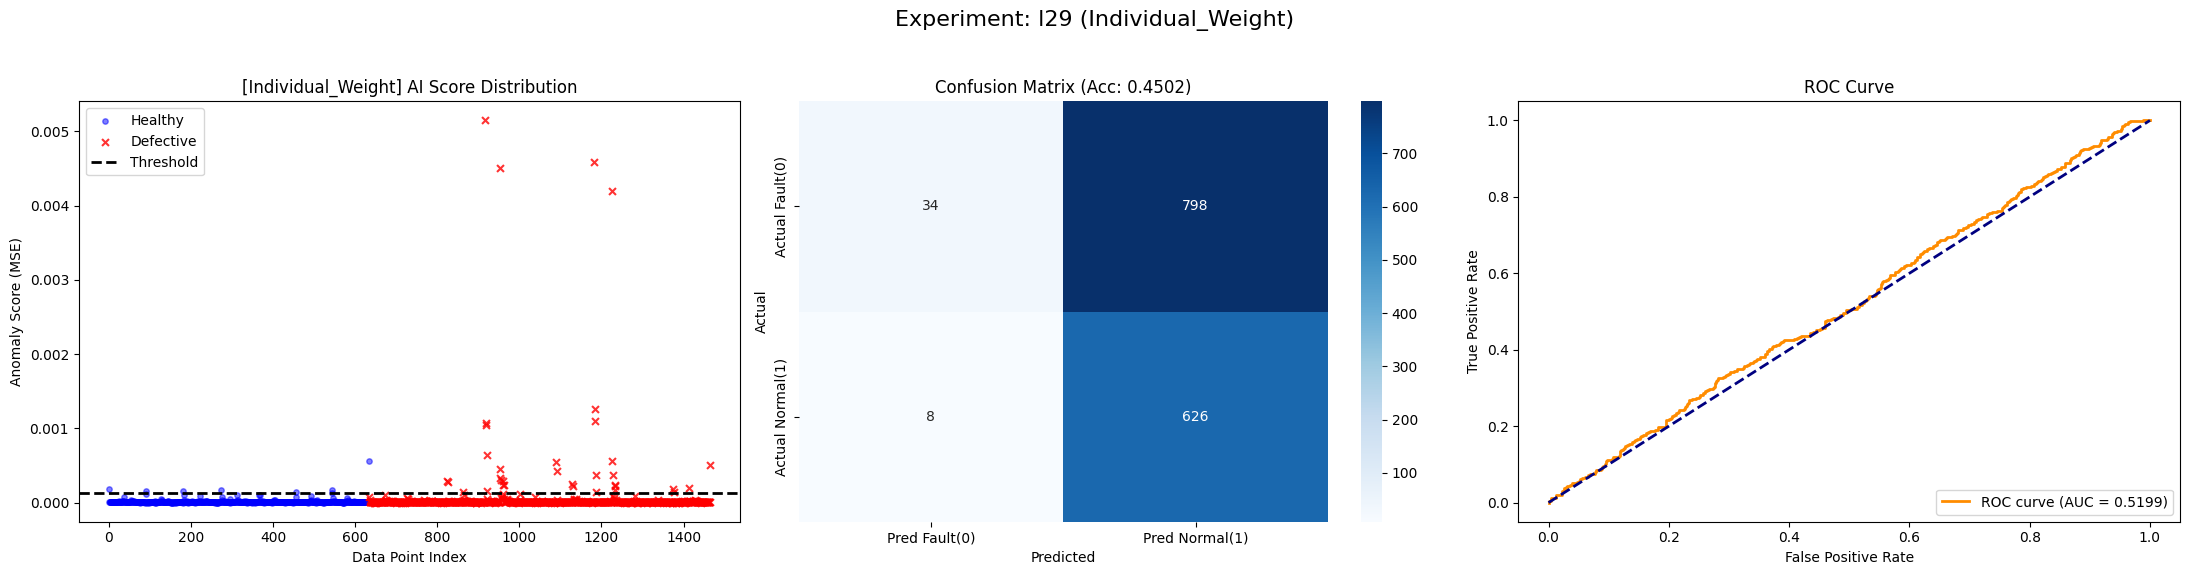

✅ [l29] 평가 완료: Acc=0.4502, AUC=0.5199


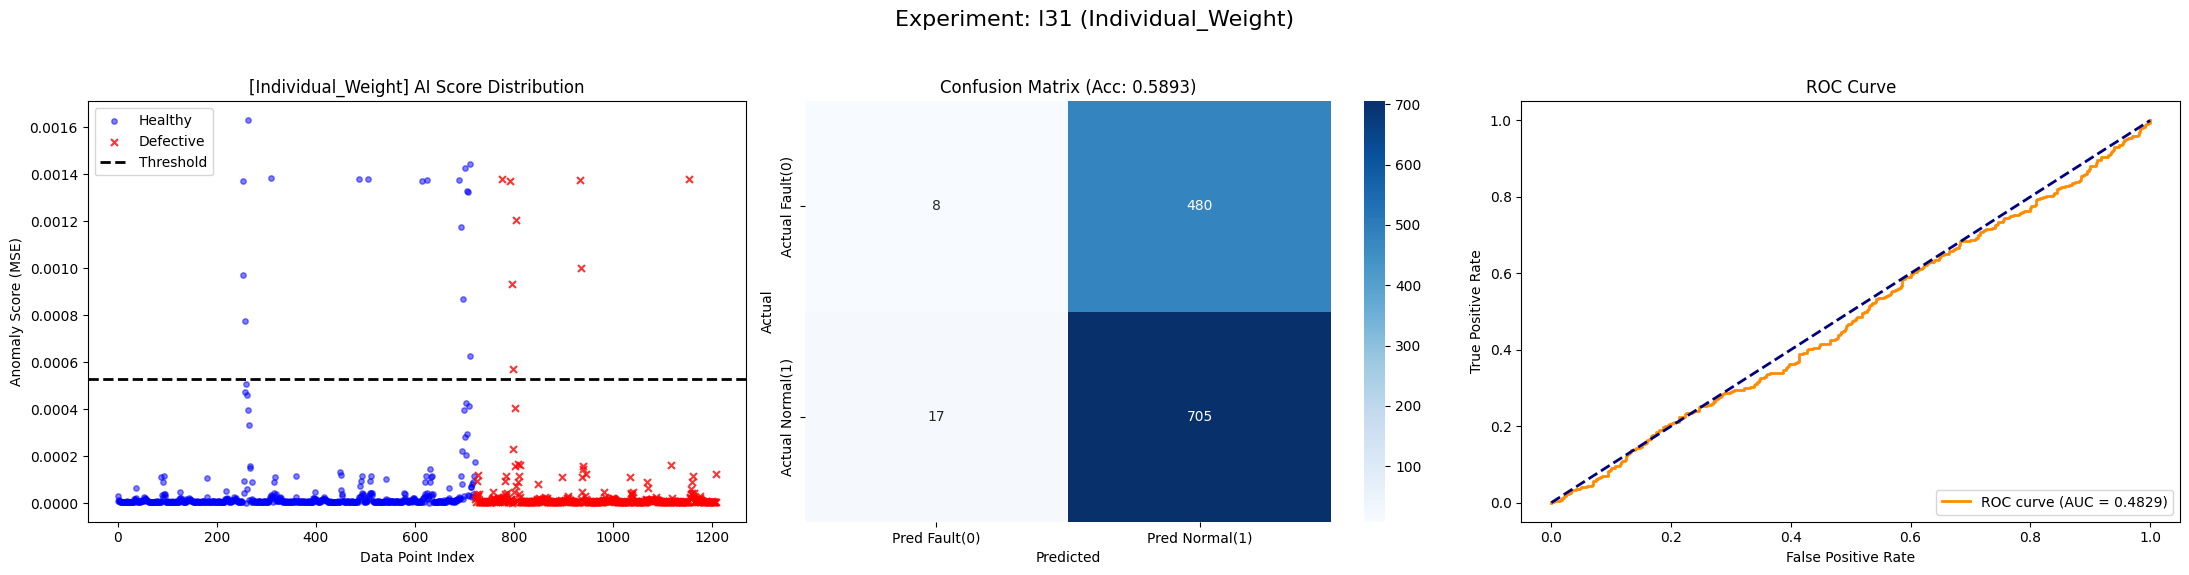

✅ [l31] 평가 완료: Acc=0.5893, AUC=0.4829


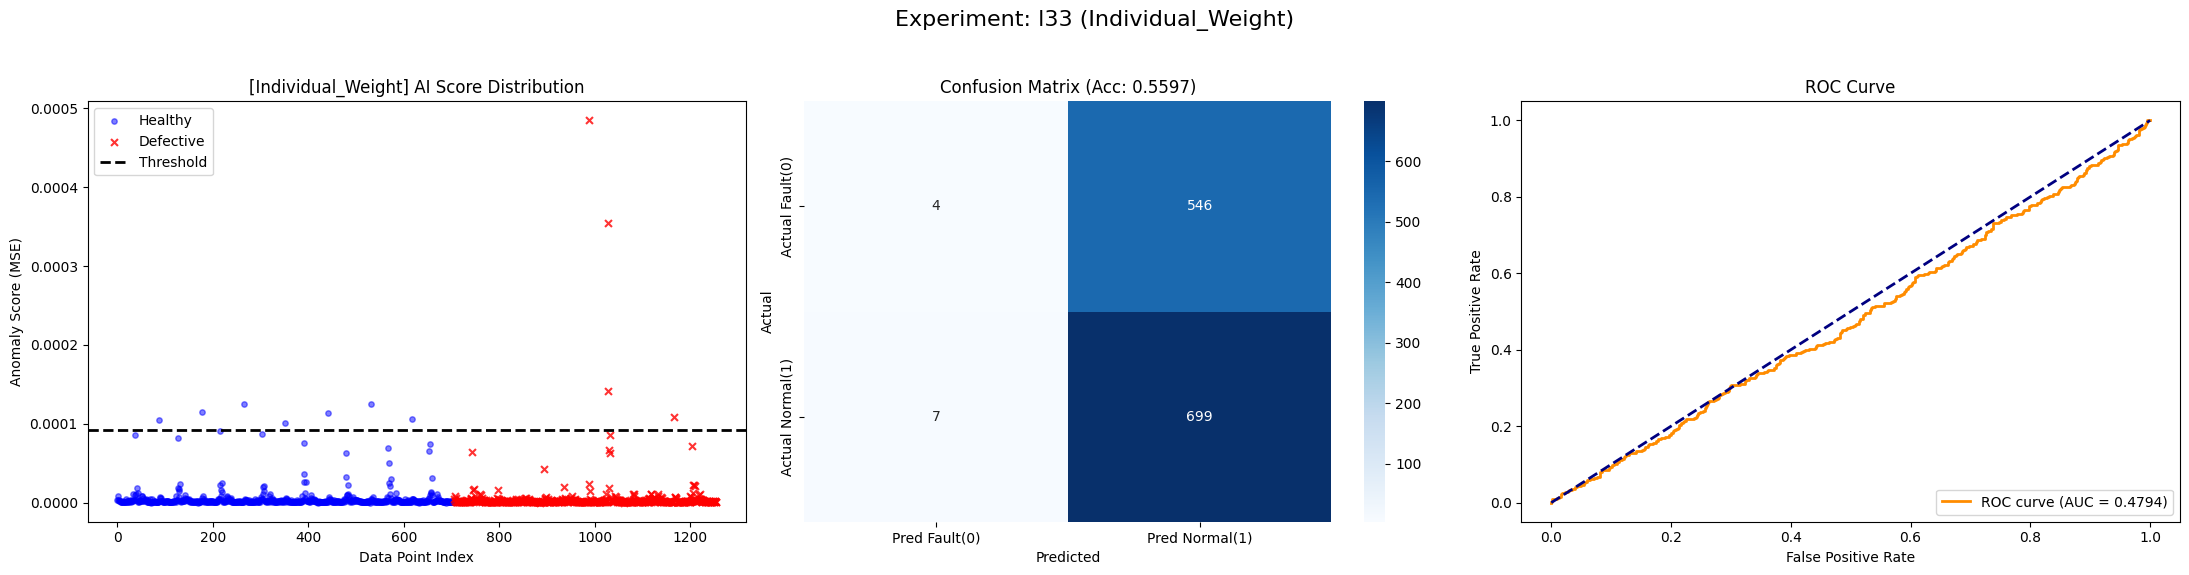

✅ [l33] 평가 완료: Acc=0.5597, AUC=0.4794

--- 최종 평가 결과 요약 ---
   Exp  Accuracy       AUC  Threshold  Train_Samples  Test_Samples
0  l29  0.450205  0.519942   0.000126           2546          1466
1  l31  0.589256  0.482908   0.000530           2589          1210
2  l33  0.559713  0.479392   0.000093           2607          1256


In [23]:
"""
LSTF-Linear, DLinear
Exp No. 29, 31, 33에 대응하는
Evaluation 및 데이터 시각화 수행
"""
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, roc_auc_score

# 1. 각 실험별 설정값 정의 (이 부분이 선언되어 있어야 합니다)
exp_configs = {
    'l29': {'clean_p': 98, 'thresh_p': 98, 'epochs': 100},
    'l31': {'clean_p': 99, 'thresh_p': 99, 'epochs': 100},
    'l33': {'clean_p': 99, 'thresh_p': 99, 'epochs': 100}
}

# 2. (선택사항) 만약 experiments 리스트가 정의되지 않았다면 추가
if 'experiments' not in locals():
    experiments = ['l29', 'l31', 'l33']

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 평가 결과 저장용
comparison_table = []

# 시각화 함수가 정의되어 있어야 합니다 (기존 plot_model_results 사용 가정)
# 만약 정의되지 않았다면 에러가 날 수 있으니 기존 코드를 참고하세요.

print(f"평가 시작: 웨이퍼 29, 31, 33에 대해 개별 가중치 적용")

for exp_id in experiments:
    # 1. 해당 실험의 설정 및 데이터/모델 불러오기
    conf = exp_configs[exp_id]
    model = models[exp_id] # 이전 단계에서 학습된 실험별 모델 (학습에 사용된게 Linear면 Linear를 추론에 사용, DLinear면 DLinear)
    exp_data = datasets[exp_id]

    X_train_raw = exp_data['X_train']
    X_test_normal = exp_data['X_test_norm']
    X_test_fault = exp_data['X_test_fault']

    # 2. 정답지(Label) 생성: Normal=1, Fault=0 (기존 코드 기준)
    y_true = [1] * len(X_test_normal) + [0] * len(X_test_fault)
    X_test_all = np.concatenate([X_test_normal, X_test_fault], axis=0)

    # 텐서 변환
    test_tensor = torch.FloatTensor(X_test_all).to(device)
    train_tensor = torch.FloatTensor(X_train_raw).to(device)

    # 3. 모델 평가 모드 전환 및 이상치 점수(AI) 계산
    model.eval()
    with torch.no_grad():
        # (A) 학습 데이터의 재구성 오차 계산 -> 임계치(Threshold) 설정용
        train_pred = model(train_tensor)
        # 차원 (샘플, 시점, 센서) 전체에 대해 MSE 계산 (sum of squares)
        tr_ai = torch.sum((train_tensor - train_pred)**2, dim=(1, 2)).cpu().numpy()

        # 설정된 퍼센타일(thresh_p)을 기준으로 임계치 결정
        thresh_val = np.percentile(tr_ai, conf['thresh_p'])

        # (B) 테스트 데이터의 재구성 오차 계산
        test_pred = model(test_tensor)
        ai_scores = torch.sum((test_tensor - test_pred)**2, dim=(1, 2)).cpu().numpy()

        # (C) 예측 수행: 점수가 임계치보다 작으면 정상(1), 크면 이상(0)
        y_pred = [1 if s <= thresh_val else 0 for s in ai_scores]

    # 4. 결과 시각화 및 성능 지표 계산
    # 기존에 사용하시던 plot_model_results 함수를 호출합니다.
    # 함수 내부에서 plt.show() 등이 실행되어 그래프가 출력됩니다.
    acc, auc = plot_model_results(exp_id, "Individual_Weight", y_true, y_pred, ai_scores, thresh_val)

    # 5. 비교 테이블 기록
    comparison_table.append({
        'Exp': exp_id,
        'Accuracy': acc,
        'AUC': auc,
        'Threshold': thresh_val,
        'Train_Samples': len(X_train_raw),
        'Test_Samples': len(X_test_all)
    })

    print(f"✅ [{exp_id}] 평가 완료: Acc={acc:.4f}, AUC={auc:.4f}")

# 최종 결과 요약 출력
import pandas as pd
df_results = pd.DataFrame(comparison_table)
print("\n--- 최종 평가 결과 요약 ---")
print(df_results)